<a href="https://colab.research.google.com/github/VMBoehm/BispectrumBias/blob/CrossPostBorn/Copy_of_TestingMAFExtensionGaussianLikelihood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     | 10.7MB 1.2MB/s


In [0]:
import corner

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

W0503 03:39:30.840438 139770617186176 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [5]:
generator_path = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path   ='./gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
maf_sampler_path      = './gdrive/My Drive/MPM/modules/gauss3b/maf-final/sampler'
maf_logprob_path      = './gdrive/My Drive/MPM/modules/gauss3b/maf-final/log_prob'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/maf-final/

log_prob  sampler


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [114]:
#finding EL2O 'by hand'
tf.reset_default_graph()

batch_size    = 256
batch_size_2  = 1
hidden_size   = 10
sample_size_z = 64
sigma_n       = 0.1
n_channels    = 1
num_comp      = 10
iaf_size      = [[512, 512], [512, 512], [512, 512], [512, 512]]
maf_prior     = tf.placeholder_with_default(True,shape=[])



sample_size_x = tf.placeholder_with_default(10,shape=[])
lr            = tf.placeholder_with_default(0.001,shape=[])

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

generator = hub.Module(generator_path, trainable=False)
encoder   = hub.Module(encoder_path, trainable=False)

# Define latent space prior
prior             = tfd.MultivariateNormalDiag(loc=tf.zeros([hidden_size]),scale_identity_multiplier=1.0)
log_det_prior     = tf.linalg.logdet(prior.covariance())

# define latent space posterior


# get some masked data
x_tr              = tf.placeholder(shape=[batch_size,784,n_channels], dtype=tf.float32)
x_re              = tf.placeholder(shape=[batch_size_2,784,n_channels], dtype=tf.float32)
prior_sample      = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)
#mymask           = tf.placeholder_with_default(np.arange((784),dtype=int),shape=[784])
sigma_corr        = tf.placeholder_with_default(np.ones([batch_size_2,784,n_channels], dtype='float32')*sigma_n,shape=[batch_size_2,784,n_channels])

encoded_data      = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma         = tf.split(encoded_data, 2, axis=-1)

sigma             = tf.nn.softplus(sigma) + 0.0001
approx_posterior  = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[batch_size,784,1])
#vae_liklogits     = tf.boolean_mask(vae_liklogits, mymask, axis=1)

# training data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
#naive_sims        = likelihood_vae.sample(sample_size_x)
naive_mean        = likelihood_vae.mean()

# test saple from prior
prior_samples     = prior.sample(sample_size_z)

sample_liklogits  = tf.reshape(generator(prior_sample),[-1,784,n_channels])
sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()


with tf.variable_scope('maf', reuse=True):
  p1= permutation(hidden_size)
  p2= permutation(hidden_size)

  chain = tfb.Chain([tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[512,512]),name='maf-1'),tfb.Permute(permutation=p1),\
                  tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[512,512]),name='maf-2'),tfb.Permute(permutation=p2),\
                  tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[512,512],shift_only=True,name='maf-3'))])
  maf = tfd.TransformedDistribution(distribution=tfd.MultivariateNormalDiag(loc=np.zeros(hidden_size, dtype='float32'),scale_identity_multiplier=1.0),bijector=chain)



loss      = -tf.reduce_mean(maf.log_prob(approx_posterior.sample()))
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op    = optimizer.minimize(loss)


### move on to estimating MAP 
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size_2,hidden_size]),shape=[batch_size_2,hidden_size])
MAP                  = tf.Variable(MAP_ini)
MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))
genMAP               = tf.reshape(generator(MAP),[batch_size_2,784,n_channels])
likeli_MAP           = tfd.Independent(tfd.Normal(loc=genMAP,scale=sigma_corr)).log_prob(x_re)

prior_MAP            = tf.cond(maf_prior, lambda:maf.log_prob(MAP), lambda: prior.log_prob(MAP))
posterior_MAP        = prior_MAP+likeli_MAP


loss_MAP             = -tf.reduce_mean(posterior_MAP)

opt_op2              = optimizer.minimize(loss_MAP, var_list=[MAP])

MAP_mean             = tfd.Independent(tfd.Normal(loc=genMAP,scale=sigma_corr)).mean()


#### do Laplace approximation
ini_val  = np.ones((batch_size_2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)

with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size_2,hidden_size)), dtype=np.float32)
  sigma_new_t = tf.constant(ini_val)
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus))
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)

update2          = tf.stop_gradient(mu_new.assign(MAP))

hess             = tf.hessians(-posterior_MAP,MAP)

hess             = tf.gather(hess, 0)

hess2            = tf.reduce_sum(hess, axis = 2 )

sigma_hess        = tf.linalg.inv(hess2)

update3          = sigma_new_t2.assign(tf.linalg.cholesky(sigma_hess))

lap_z_samples    = tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size])

lap_liklogits   = tf.reshape(generator(lap_z_samples),[-1,784,n_channels])
lap_likelihood  = tfd.Independent(tfd.Normal(loc=lap_liklogits,scale=sigma_corr))
lap_mean        = lap_likelihood.mean()
lapl_variance_MAP = tf.linalg.diag_part(approx_posterior_laplace.covariance())


# # construct a GMM approximation from different minima

with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
  mu_gmm      = tf.Variable(np.ones((batch_size_2,num_comp,hidden_size)), dtype=np.float32)
  ini_val2    = np.ones((batch_size_2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
  sigma_gmm   = tf.constant(ini_val2)
  sigma_gmmt  = tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_gmm), transform=tf.nn.softplus))
  w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)

mu_est        = tf.placeholder_with_default(tf.zeros([batch_size_2,num_comp,hidden_size]),shape=[batch_size_2,num_comp,hidden_size])
sigma_est     = tf.placeholder_with_default(tf.ones([batch_size_2,num_comp,hidden_size, hidden_size]),shape=[batch_size_2,num_comp,hidden_size, hidden_size])
w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_a      = w_gmm.assign(w_est)
update_b      = mu_gmm.assign(mu_est)
update_c      = sigma_gmmt.assign(sigma_est)

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

gmm_sample_z  = gmm.sample(sample_size_z)
#gmm_sample_x  = tfd.Independent(tfd.Normal(loc=tf.reshape(generator(gmm_sample_z),[-1,784,n_channels]),scale=sigma_corr)).mean()

saver         = tf.train.Saver()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0503 06:23:57.270355 139770617186176 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0503 06:23:57.360051 139770617186176 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0503 06:23:57.486270 139770617186176 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0503 06:23:59.434879 139770617186176 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0503 06:24:02.772978 139770617186176 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

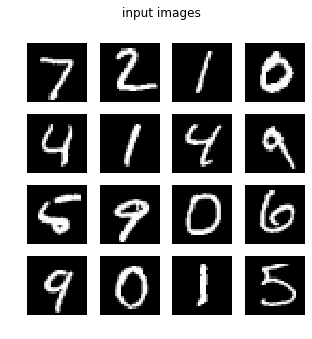

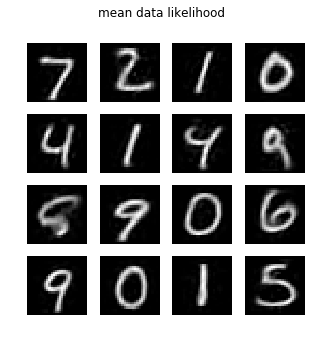

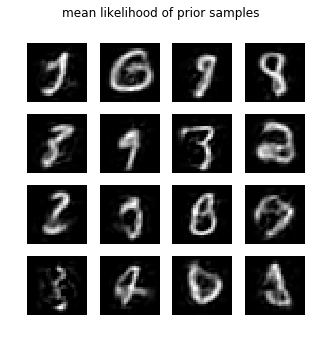

In [117]:
samples = sess.run(prior_samples, feed_dict={x_tr: np.expand_dims(x_truth,-1)})
samples.shape
inim, res, s = sess.run([x_tr,naive_mean,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_sample: samples})
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(res[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean likelihood of prior samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
posterior_loss=[]
ii     = 0
nepoch = 0
learning_rate=1e-3

In [0]:
#train the maf
while nepoch<1000:
  if (ii+1)*batch_size>len(x_train): 
    ii=0
    nepoch+=1
    print('starting epoch', nepoch)
  if nepoch>200:
    learning_rate=1e-3
  x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
  _, ll = sess.run([opt_op,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
  posterior_loss+=[ll]
  if ii%500==0:
    print(ll)
  ii+=1

13.6125765
starting epoch 1
10.905176
starting epoch 2
10.439826
starting epoch 3
10.14778
starting epoch 4
9.944385
starting epoch 5
9.794495
starting epoch 6
9.668623
starting epoch 7
9.593668
starting epoch 8
9.520043
starting epoch 9
9.496139
starting epoch 10
9.434414
starting epoch 11
9.382611
starting epoch 12
9.334607
starting epoch 13
9.323811
starting epoch 14
9.253218
starting epoch 15
9.254667
starting epoch 16
9.249868
starting epoch 17
9.23633
starting epoch 18
9.18848
starting epoch 19
9.163538
starting epoch 20
9.145468
starting epoch 21
9.076312
starting epoch 22
9.1072445
starting epoch 23
9.094762
starting epoch 24
9.053941
starting epoch 25
9.074233
starting epoch 26
9.006826
starting epoch 27
9.056843


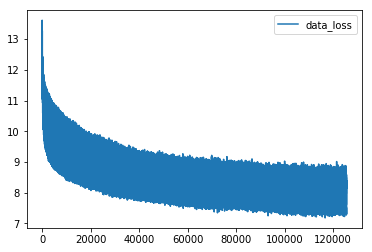

In [51]:
plt.figure()
plot(posterior_loss,label='data_loss')
legend()

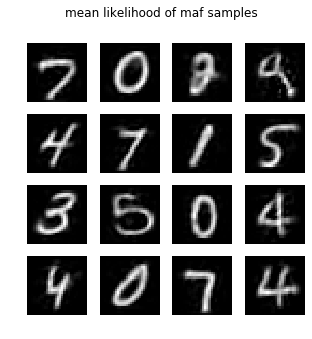

In [52]:
samples1 = sess.run(maf.sample(sample_size_z))
print(test)
#samples.shape
s = sess.run(sample_mean, feed_dict={prior_sample: samples1})



figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
# s = sess.run(sample_mean, feed_dict={prior_sample: samples2})
# figure(figsize=(5,5))
# suptitle('mean likelihood of maf samples')
# for i in range(16):
#     subplot(4,4,i+1)
#     imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
#     axis('off')

In [0]:

#maf_log_prob.export(maf_logprob_path,sess)
#maf_sampler.export(maf_sampler_path,sess)

In [53]:
maf_s, prior_s = sess.run([maf.sample(10000), prior.sample(10000)])
print(maf_s.shape)

(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


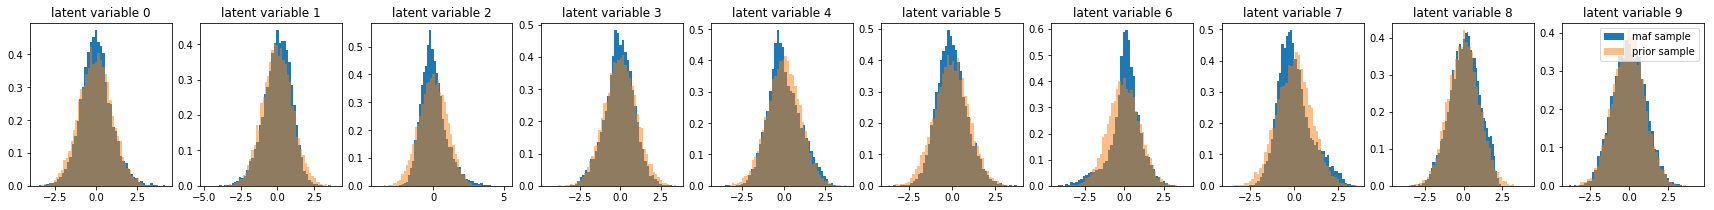

In [54]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

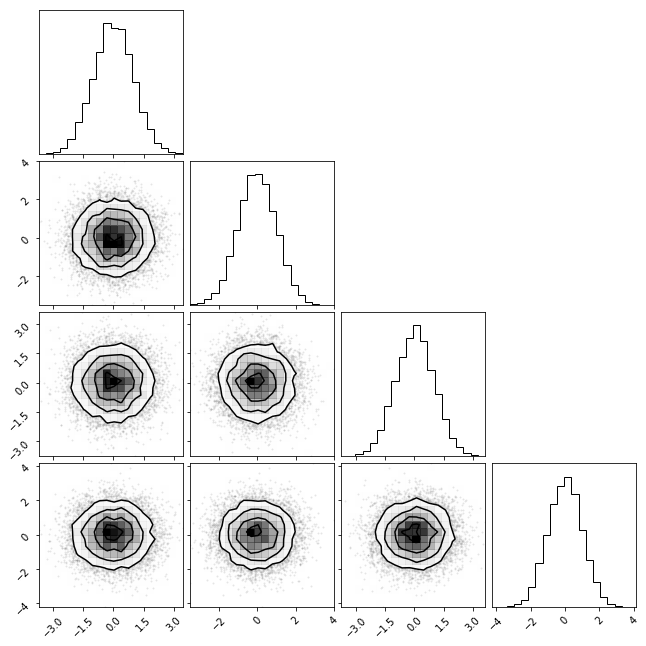

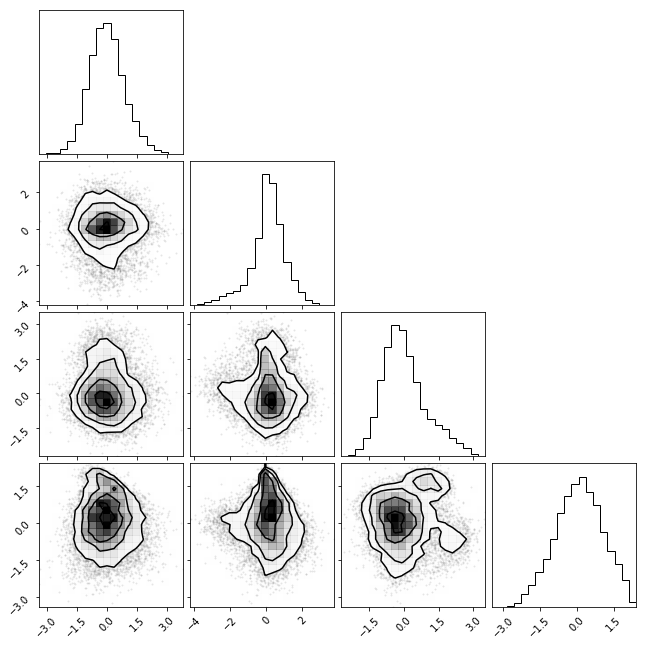

In [55]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])

0
4187.4565
3794.5754
3725.6328
switching to lr 0.01
3725.0796
3725.1724
3725.1555
3725.1262
3725.1233
switching to lr 0.001
3725.096
3725.122
1
4527.5146
3387.0417
3365.56
switching to lr 0.01
3365.5498
3365.5586
3365.5562
3365.5535
3365.5566
switching to lr 0.001
3365.5493
3365.577
2
4470.9946
3559.2346
3507.859
switching to lr 0.01
3507.8633
3507.8582
3507.8691
3507.872
3507.8633
switching to lr 0.001
3507.8567
3507.8591
3
4307.044
3439.2856
3438.6816
switching to lr 0.01
3438.687
3438.694
3438.6882
3438.6924
3438.6812
switching to lr 0.001
3438.6934
3438.6934
4
4379.7153
2811.1638
2656.4124
switching to lr 0.01
2655.5579
2655.5598
2655.5623
2655.5596
2655.563
switching to lr 0.001
2655.561
2655.5618
5
4567.8364
3799.2905
3798.1128
switching to lr 0.01
3798.1213
3798.114
3798.1199
3798.1367
3798.1274
switching to lr 0.001
3798.126
3798.1191
6
4381.549
2735.1677
2655.696
switching to lr 0.01
2655.5586
2655.5605
2655.562
2655.5596
2655.5598
switching to lr 0.001
2655.5637
2655.5615
7


KeyboardInterrupt: ignored

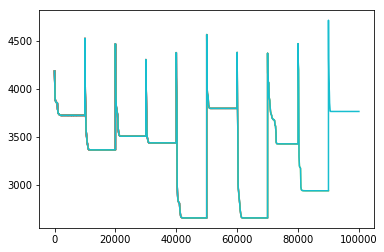

In [56]:
inc = 6
x_truth   = x_test[inc:batch_size_2+inc]
sigma_new = np.ones([28,28])*sigma_n
sigma_new[0:28,12:18]=1e8
mask=np.ones([28,28])
mask[np.where(sigma_new==1e8)]=0

data        = np.expand_dims(x_truth,-1)
sigma_new   = sigma_new.reshape([batch_size_2,784,n_channels])
mask        = mask.reshape([batch_size_2,784,n_channels])
data        = data*mask


posterior_loss2=[]
ini = np.zeros((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))

# l_minima=[]
# map_minima=[]
for ii in range(20):
  print(ii)
  ini = np.random.rand((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(3000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  print('switching to lr', lrate)
  for ii in range(5000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for ii in range(2000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  plot(posterior_loss2,label='data_loss')
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_re: data, sigma_corr:sigma_new})]

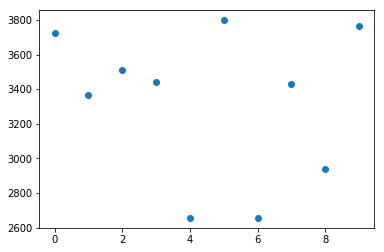

In [57]:
plt.figure()
plt.plot(np.arange(10),l_minima,ls='',marker='o')
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


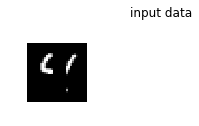

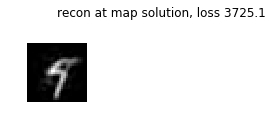

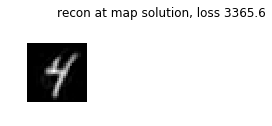

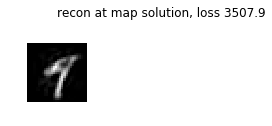

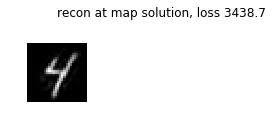

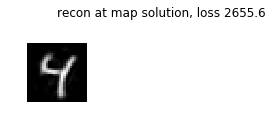

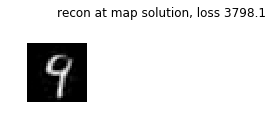

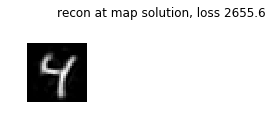

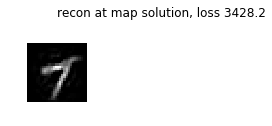

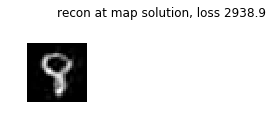

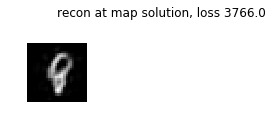

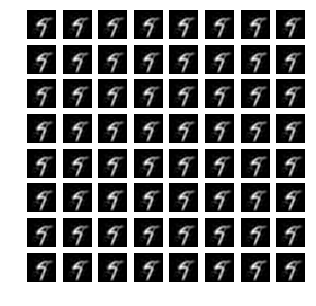

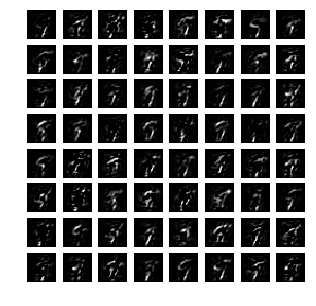

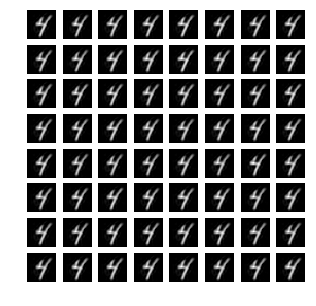

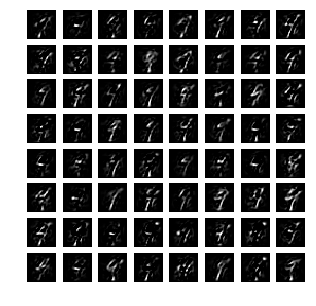

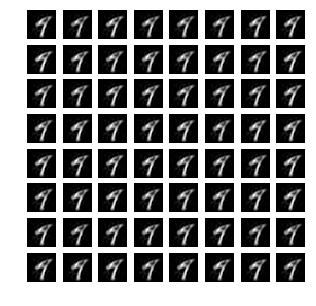

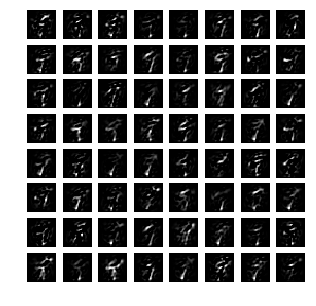

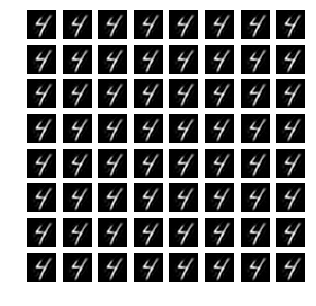

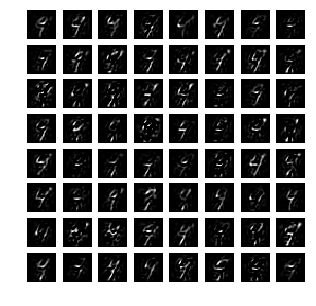

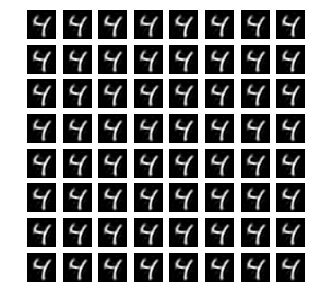

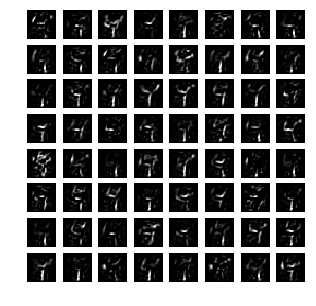

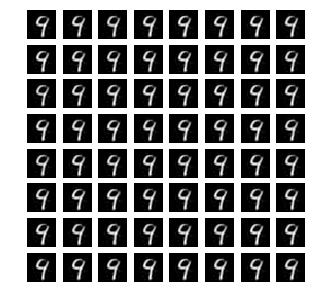

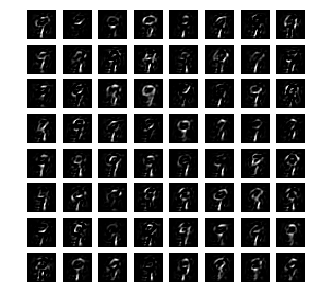

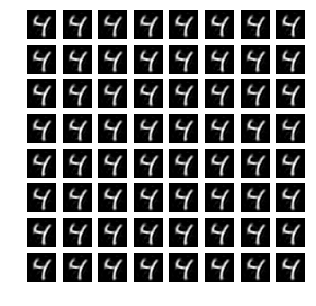

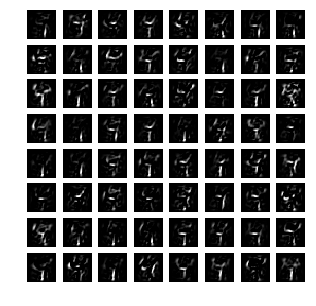

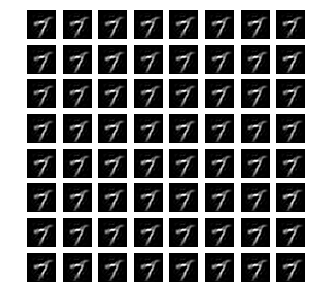

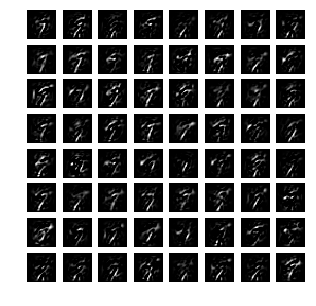

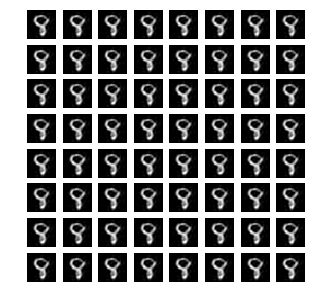

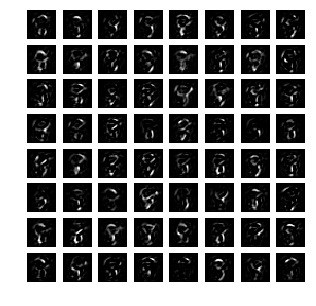

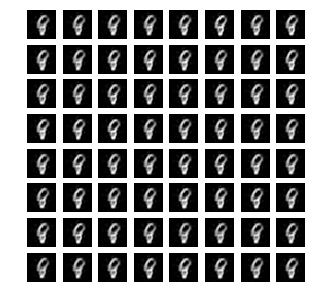

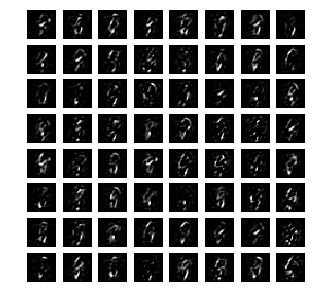

In [58]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')



for ii,ini_ in enumerate(map_minima):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new})
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size_2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      
varis=[]   
for ii,ini_ in enumerate(map_minima):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new})      
  _ = sess.run(update2,feed_dict={x_re: data, sigma_corr:sigma_new})
  _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new})
  
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_re: data, sigma_corr:sigma_new})]
  
  #z_samples = sess.run(lap_z_samples,feed_dict={x_re: data, sigma_corr:sigma_new})
  l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new})
  figure(figsize=(5,5))
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  figure(figsize=(5,5))
  mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))
  for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(l_samples[i,:,0],(28,28))-mean_sample,cmap='gray',vmin=0)
    axis('off')    


W0503 05:59:57.305938 139770617186176 legend.py:1289] No handles with labels found to put in legend.


(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10


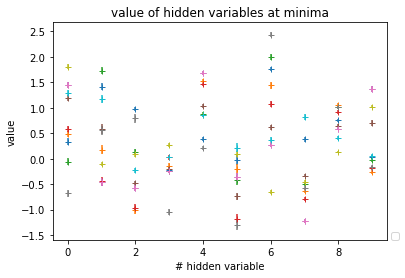

In [98]:
varis=np.asarray(varis)
map_minima=np.asarray(map_minima)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima)):
  print(map_minima.shape)
  yerr_= np.sqrt(varis[ii,0])
  print(len(yerr))
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

0
8501.481
4162.9375
3866.648
3813.561
3705.5417
3702.9314
3702.9038
3702.9075
3702.9636
3702.99
1
5362.586
2941.9287
2923.502
2923.0818
2923.0835
2923.0896
2923.0806
2923.097
2923.0825
2923.086
2
6616.443
3845.3403
3688.397
3419.852
3331.212
3329.38
3329.374
3329.3945
3329.4058
3329.3845
3
5679.009
3935.2302
3934.3682
3934.3667
3934.4028
3934.4028
3934.4207
3934.3826
3934.3896
3934.3804
4
6373.593
3848.9375
3690.6055
3645.5781
3639.4976
3639.5
3639.4834
3639.489
3639.5176
3639.4858
5
4429.383
2935.2244
2869.872
2869.7378
2869.7395
2869.746
2869.74
2869.745
2869.7393
2869.743
6
5580.0444
3661.345
3618.8657
3615.518
3615.5054
3615.5159
3615.5208
3615.5242
3615.5103
3615.5105
7
3661.2312
2702.2214
2656.1787
2656.1921
2656.172
2656.1584
2656.1855
2656.1687
2656.1824
2656.1572
8
4481.7725
2896.0894
2850.0688
2849.2478
2849.2476
2849.2456
2849.2544
2849.247
2849.2466
2849.255
9
5216.133
3730.1465
3707.8748
3707.8542
3707.8855
3707.9282
3707.9678
3707.8728
3707.8743
3707.8809


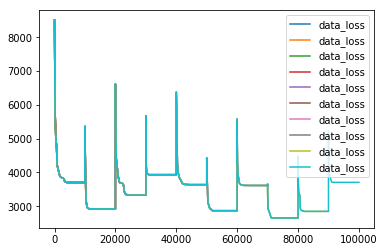

In [100]:
l_minima_old=[]
map_minima_old=[]
posterior_loss3=[]
for ii in range(10):
  print(ii)
  ini = np.random.randn((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini, maf_prior: False, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(3000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, maf_prior: False, sigma_corr:sigma_new})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  for ii in range(5000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, maf_prior: False, sigma_corr:sigma_new})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-4
  for ii in range(2000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, maf_prior: False, sigma_corr:sigma_new})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  l_minima_old+=[ll]
  map_minima_old+=[sess.run([MAP],feed_dict={x_re: data, sigma_corr:sigma_new, maf_prior: False})]
  plot(posterior_loss3,label='data_loss')
  legend()

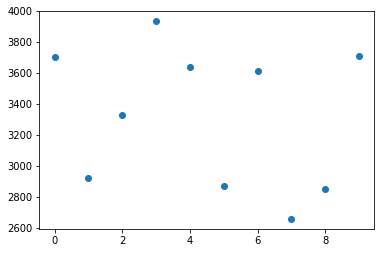

In [101]:
plt.figure()
plt.plot(np.arange(10),l_minima_old,ls='',marker='o')
plt.show()

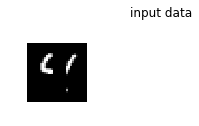

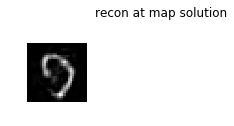

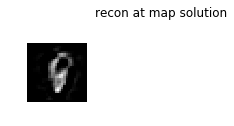

In [102]:
mean_at_map_2 = sess.run(MAP_mean,feed_dict={x_re: data, maf_prior: False, sigma_corr: sigma_new})



figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')

figure(figsize=(5,5))
suptitle('recon at map solution')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean_at_map_2[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
    

figure(figsize=(5,5))
suptitle('recon at map solution')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape((mean_at_map-mean_at_map_2)[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


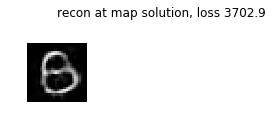

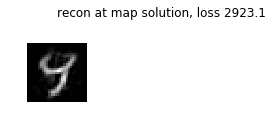

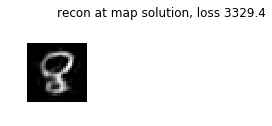

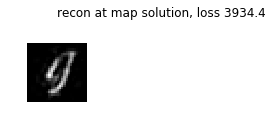

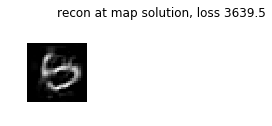

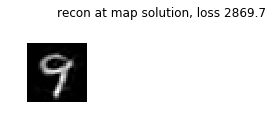

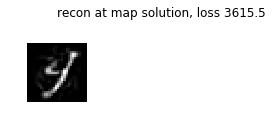

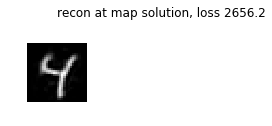

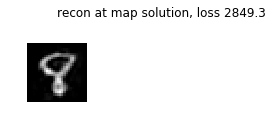

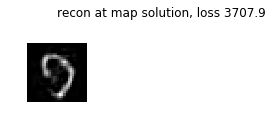

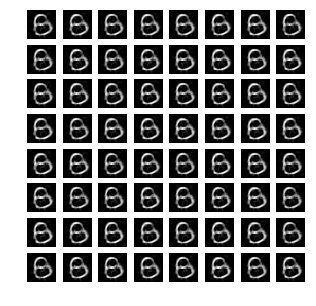

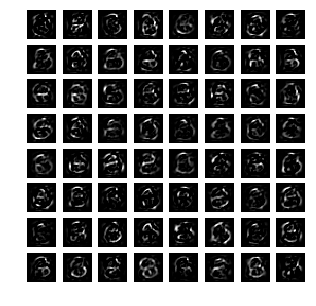

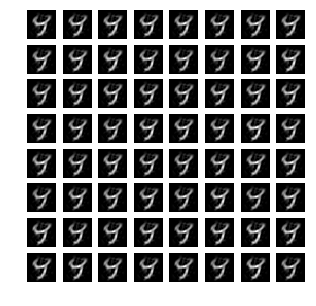

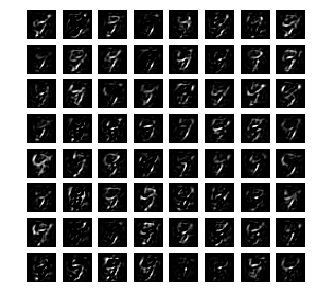

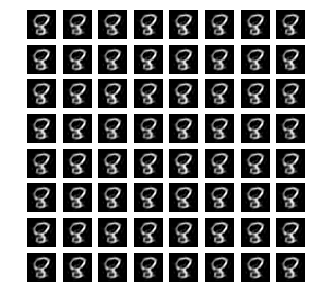

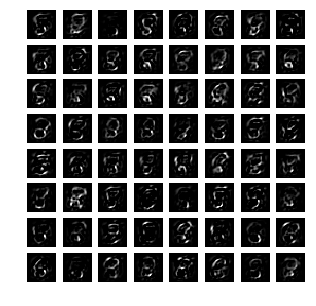

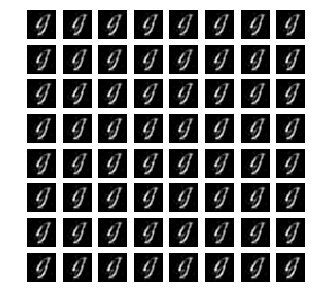

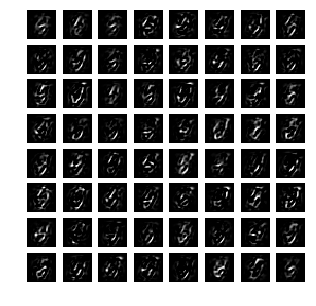

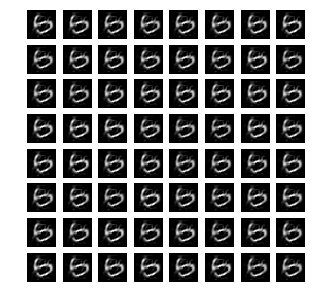

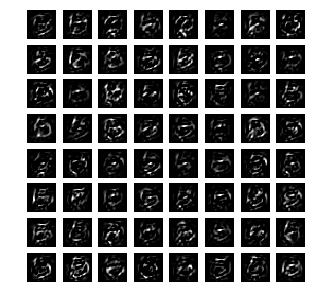

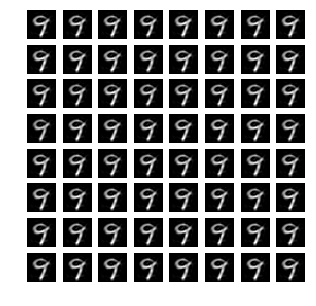

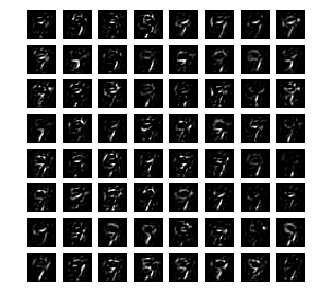

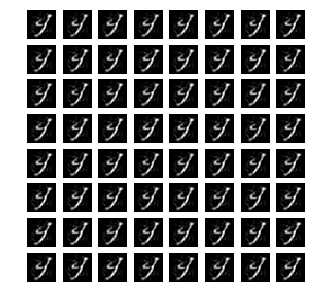

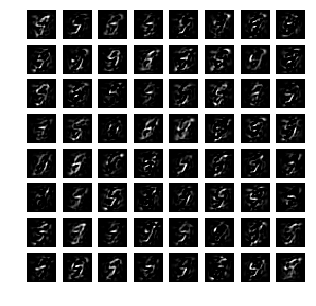

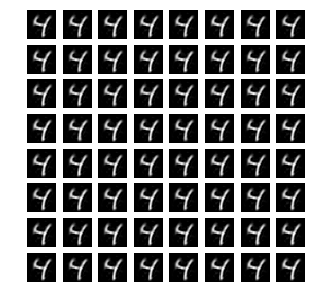

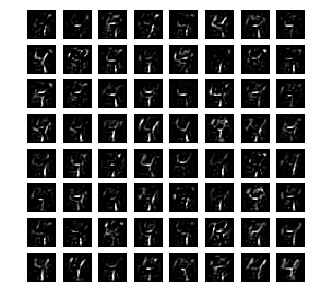

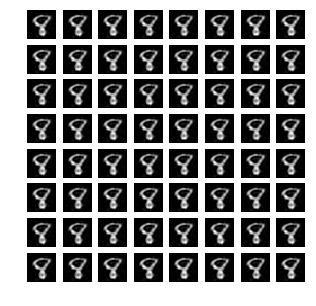

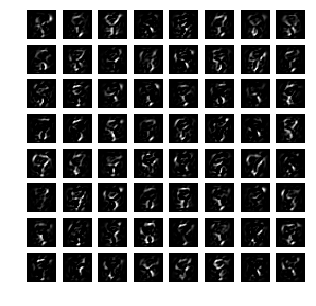

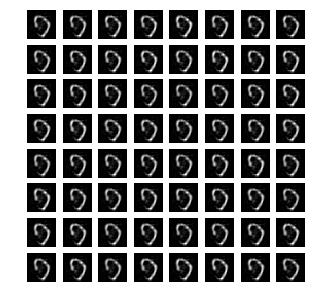

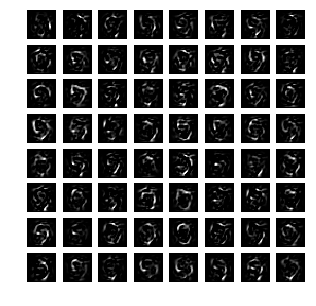

In [104]:
for ii,ini_ in enumerate(map_minima_old):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new,maf_prior: False})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima_old[ii])
  for i in range(min(batch_size_2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')


varis=[]
for ii,ini_ in enumerate(map_minima_old):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new,maf_prior: False})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  _ = sess.run(update2,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new, maf_prior: False})
  l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})]
  #print(l_samples.shape)
  figure(figsize=(5,5))
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  figure(figsize=(5,5))   
  mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))
  for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(l_samples[i,:,0],(28,28))-mean_sample,cmap='gray',vmin=0)
    axis('off')    
    

W0503 06:15:08.457504 139770617186176 legend.py:1289] No handles with labels found to put in legend.


(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10


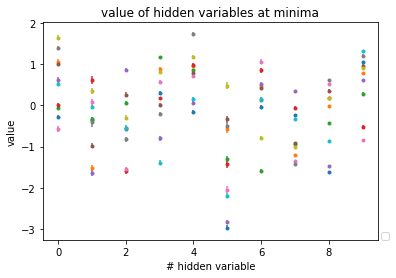

In [106]:
varis=np.asarray(varis)
map_minima_old=np.asarray(map_minima_old)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima_old)):
  print(map_minima_old.shape)
  yerr_= np.sqrt(varis[ii,0])
  print(len(yerr))
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima_old[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()